In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from flax import struct
from functools import partial

from flax.nnx.nn.initializers import constant, orthogonal
from flax.nnx import GraphDef, GraphState
import numpy as np
import optax
from typing import Sequence, NamedTuple, Any
import distrax
from test_vari.single_env.wrappers import (
    LogWrapper,
    BraxGymnaxWrapper,
    VecEnv,
    NormalizeVecObservation,
    NormalizeVecReward,
    ClipAction,
)

2025-02-18 19:14:20.655474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739902460.668683   31981 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739902460.673048   31981 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class ActorCritic(nnx.Module):
    def __init__(self, in_features, out_features, activation, rngs):
        if activation == 'relu':
            self.activation = nnx.relu
        else:
            self.activation = nnx.tanh

        self.act_dense1 = nnx.Linear(in_features, 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.), rngs=rngs)
        self.act_dense2 = nnx.Linear(64, 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.), rngs=rngs)
        self.act_dense3 = nnx.Linear(64, out_features, kernel_init=orthogonal(0.01), bias_init=constant(0.), rngs=rngs)

        self.log_std = nnx.Param(jnp.zeros(out_features))

        self.cri_dense1 = nnx.Linear(in_features, 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.), rngs=rngs)
        self.cri_dense2 = nnx.Linear(64, 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.), rngs=rngs)
        self.cri_dense3 = nnx.Linear(64, 1, kernel_init=orthogonal(1.), bias_init=constant(0.), rngs=rngs)

    def __call__(self, x):
        actor_mean = self.act_dense1(x)
        actor_mean = self.activation(actor_mean)
        actor_mean = self.act_dense2(actor_mean)
        actor_mean = self.activation(actor_mean)
        actor_mean = self.act_dense3(actor_mean)
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(jnp.asarray(self.log_std)))

        critic = self.cri_dense1(x)
        critic = self.activation(critic)
        critic = self.cri_dense2(critic)
        critic = self.activation(critic)
        critic = self.cri_dense3(critic)

        return pi, jnp.squeeze(critic, axis=-1)

In [4]:
class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

@struct.dataclass
class TrainState:
    graph_def: GraphDef
    state: GraphState

In [5]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv

In [6]:
def my_env_creator(params, battery_type, demand_profile):
    env = MicroGridEnv(params, battery_type, demand_profile)
    return env, env.params

In [7]:
# states = []

In [8]:
def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    # env, env_params = BraxGymnaxWrapper(config["ENV_NAME"]), None
    env, env_params = my_env_creator(config['my_params'], config['battery_type'], config['demand_profile'])
    env = LogWrapper(env)
    # env = ClipAction(env, low=env_params.i_min_action, high=env_params.i_max_action)
    env = VecEnv(env)       #todo da togliere eventually
    if config["NORMALIZE_ENV"]:
        env = NormalizeVecObservation(env)
        env = NormalizeVecReward(env, config["GAMMA"])

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac



    _rng = nnx.Rngs(123)
    network = ActorCritic(
        env.observation_space(env_params).shape[0], env.action_space(env_params).shape[0], activation=config["ACTIVATION"], rngs=_rng
    )

    if config["ANNEAL_LR"]:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(learning_rate=linear_schedule, eps=1e-5),
        )
    else:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(config["LR"], eps=1e-5),
        )

    optimizer = nnx.Optimizer(network, tx)

    graph_def, state = nnx.split((network, optimizer))

    train_state = TrainState(graph_def=graph_def, state=state)

    return env, env_params, train_state

@partial(jax.jit, static_argnums=(0,), donate_argnums=(2,))
def train(env, env_params, train_state, rng):
    # INIT NETWORK
    rng, _rng = jax.random.split(rng)

    ##### era qui

    # jax.debug.print('aa', ordered=True)
    # print('aa')

    # INIT ENV
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
    obsv, env_state = env.reset(reset_rng, env_params)

    # TRAIN LOOP
    def _update_step(runner_state, unused):
        # COLLECT TRAJECTORIES
        # jax.debug.print('cc', ordered=True)
        # print('cc')
        # print(jax.tree.map(lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype), runner_state))
        # states.append(jax.tree.map(lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype), runner_state))

        def _env_step(runner_state, unused):
            train_state, env_state, last_obs, rng = runner_state

            network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)
            pi, value = network(last_obs)

            action = pi.sample(seed=_rng)
            log_prob = pi.log_prob(action)

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, reward, done, info = env.step(
                rng_step, env_state, action, env_params
            )
            # jax.debug.print('reward: {r}', r=reward, ordered=True)
            transition = Transition(
                done, action, value, reward, log_prob, last_obs, info
            )
            runner_state = (train_state, env_state, obsv, rng)
            return runner_state, transition

        runner_state, traj_batch = jax.lax.scan(
            _env_step, runner_state, None, config["NUM_STEPS"]
        )

        # jax.debug.print('dd', ordered=True)
        # print('dd')
        # states.append(jax.tree.map(lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype), runner_state))

        # CALCULATE ADVANTAGE
        train_state, env_state, last_obs, rng = runner_state
        network, optimizer = nnx.merge(train_state.graph_def, train_state.state)
        _, last_val = network(last_obs)

        # jax.debug.print('ee', ordered=True)
        # print('ee')

        def _calculate_gae(traj_batch, last_val):
            def _get_advantages(gae_and_next_value, transition):
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                gae = (
                    delta
                    + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                )
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        # print('ff')

        # UPDATE NETWORK
        def _update_epoch(update_state, unused):
            def _update_minbatch(train_state, batch_info):
                traj_batch, advantages, targets = batch_info

                def _loss_fn(network, traj_batch, gae, targets):
                    # RERUN NETWORK
                    pi, value = network(traj_batch.obs)
                    log_prob = pi.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (
                        value - traj_batch.value
                    ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = (
                        0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                    )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["CLIP_EPS"],
                            1.0 + config["CLIP_EPS"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = (
                        loss_actor
                        + config["VF_COEF"] * value_loss
                        - config["ENT_COEF"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

                grad_fn = nnx.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn(
                    network, traj_batch, advantages, targets
                )

                optimizer.update(grads)
                train_state = train_state.replace(state=nnx.state((network, optimizer)))
                return train_state, total_loss

            train_state, traj_batch, advantages, targets, rng = update_state
            rng, _rng = jax.random.split(rng)
            batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
            assert (
                batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
            ), "batch size must be equal to number of steps * number of envs"
            permutation = jax.random.permutation(_rng, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = jax.tree_util.tree_map(
                lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
            )
            shuffled_batch = jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )
            minibatches = jax.tree_util.tree_map(
                lambda x: jnp.reshape(
                    x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                ),
                shuffled_batch,
            )
            train_state, total_loss = jax.lax.scan(
                _update_minbatch, train_state, minibatches
            )
            update_state = (train_state, traj_batch, advantages, targets, rng)
            return update_state, total_loss

        update_state = (train_state, traj_batch, advantages, targets, rng)

        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
        )
        # print('gg')
        train_state = update_state[0]
        metric = traj_batch.info
        rng = update_state[-1]
        # print('hh')
        if config.get("DEBUG"):

            def callback(info):
                return_values = info["returned_episode_returns"][
                    info["returned_episode"]
                ]
                timesteps = (
                    info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                )
                for t in range(len(timesteps)):
                    print(
                        f"global step={timesteps[t]}, episodic return={return_values[t]}"
                    )

            jax.debug.callback(callback, metric)

        runner_state = (train_state, env_state, last_obs, rng)    #todo rimettere
        # print(train_state.state)
        # states.append(jax.tree.map(lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype), runner_state))
        # print('ii')
        return runner_state, metric

    rng, _rng = jax.random.split(rng)
    runner_state = (train_state, env_state, obsv, _rng)
    # jax.debug.print('bb', ordered=True)
    # print('bb')
    runner_state, metric = jax.lax.scan(
        _update_step, runner_state, None, config["NUM_UPDATES"]
    )

    # print('zz')

    return {"runner_state": runner_state, "metrics": metric}

In [9]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [10]:
pack_options = "ernestogym/ernesto_jax/data/battery/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery/models/aging/bolun_pack_dropflow.yaml"
world = "ernestogym/envs_jax/single_agent/world_deg.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=False

)

params['step'] = 60*60
params['step']

3600

In [11]:
a = jnp.array([[[[[[[2]]]]]]])
a = jnp.clip(a, 0, 1)
a.flatten()[0]
b = jnp.array(3)
b.flatten()

Array([3], dtype=int32, weak_type=True)

In [12]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 1,
    "NUM_STEPS": 10000,
    "TOTAL_TIMESTEPS": 250000,
    "UPDATE_EPOCHS": 25,
    "NUM_MINIBATCHES": 10,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.95,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": None,
    "ANNEAL_LR": True,
    'my_params': params,
    'battery_type': 'degrading_dropflow',
    'demand_profile': '64',
    'DEBUG': False
}

rng = jax.random.PRNGKey(42)
env, env_params, train_state = make_train(config)
# out = train_jit(rng)

In [13]:
config.get('DEBUG')

False

time: 58.21 s


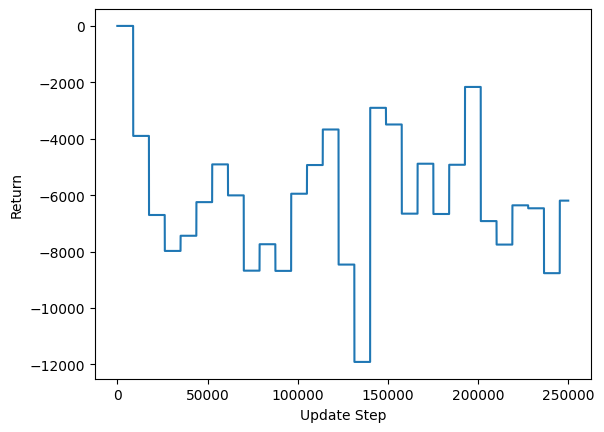

In [14]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = jax.block_until_ready(train(env, env_params, train_state, rng))

train_state = out['runner_state'][0]

print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [15]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(250000,)

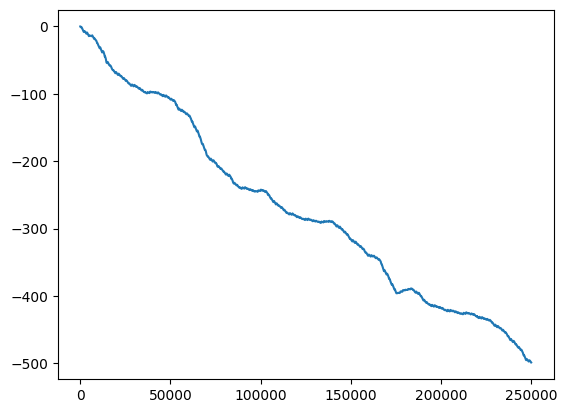

In [16]:
plt.plot(r_trad_cum)

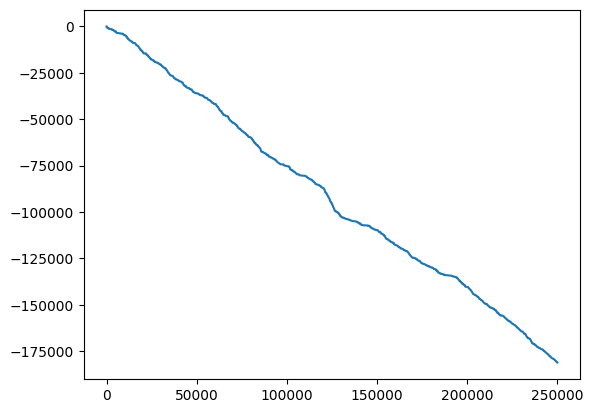

In [17]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [ ]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv

In [19]:
@partial(jax.jit, static_argnums=(0, 3))
def test(env: MicroGridEnv, env_params, train_state, num_iter, rng):
    network, _ = nnx.merge(train_state.graph_def, train_state.state)

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, info

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, None, num_iter)

    return info

In [20]:
env, env_params = my_env_creator(params, config['battery_type'], '65')
env_params = env.eval(env_params)

In [21]:
num_iter = 50000
info = test(env, env_params, train_state, num_iter, jax.random.PRNGKey(45645))


In [22]:
jax.tree.map(lambda val: val.shape, info)

{'i_to_apply': (50000,),
 'norm_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)},
 'pure_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)},
 'r_tot': (50000,),
 'soc': (50000,),
 'soh': (50000,),
 'weig_reward': {'r_clipping': (50000,),
  'r_deg': (50000,),
  'r_op': (50000,),
  'r_trad': (50000,)}}

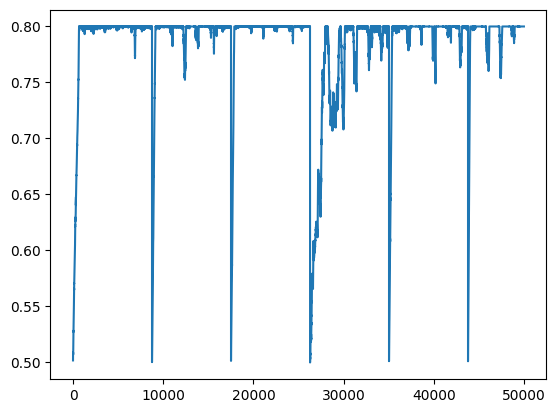

In [23]:
plt.plot(info['soc'])

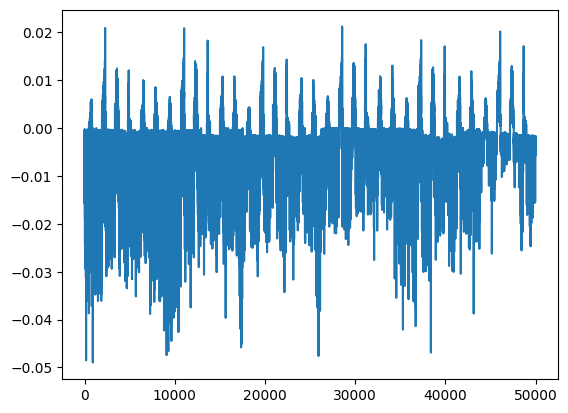

In [24]:
plt.plot(info['weig_reward']['r_trad'])

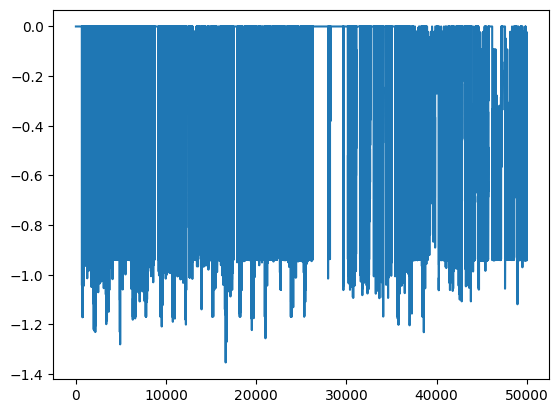

In [25]:
plt.plot(info['weig_reward']['r_clipping'])

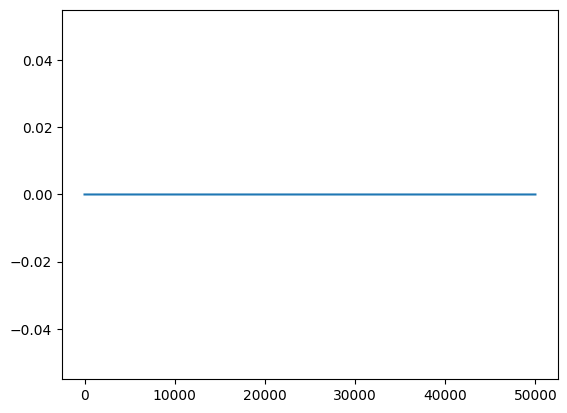

In [26]:
plt.plot(info['weig_reward']['r_op'])

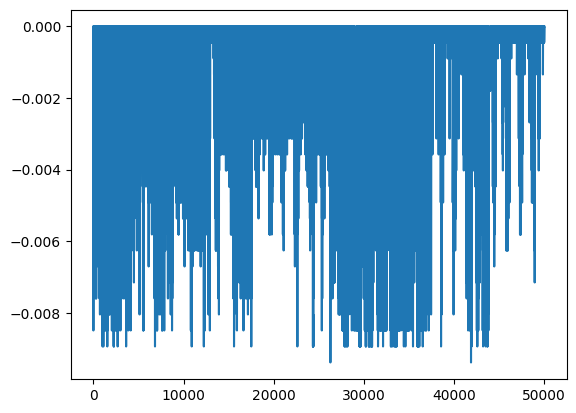

In [27]:
plt.plot(info['weig_reward']['r_deg'])

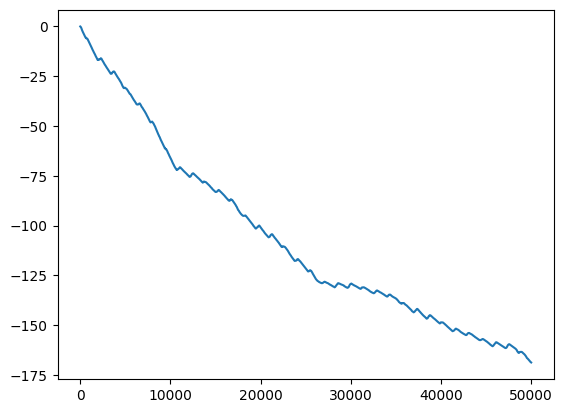

In [28]:
plt.plot(np.cumsum(info['weig_reward']['r_trad']))

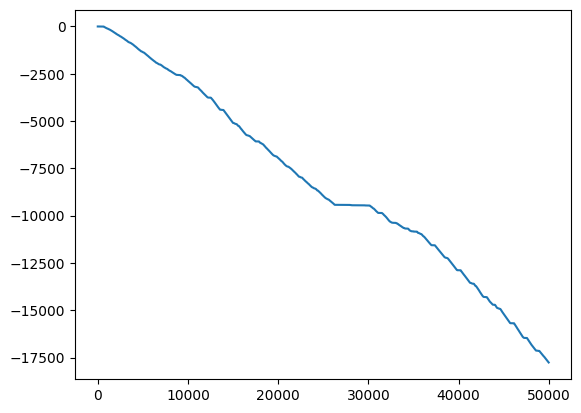

In [29]:
plt.plot(np.cumsum(info['weig_reward']['r_clipping']))

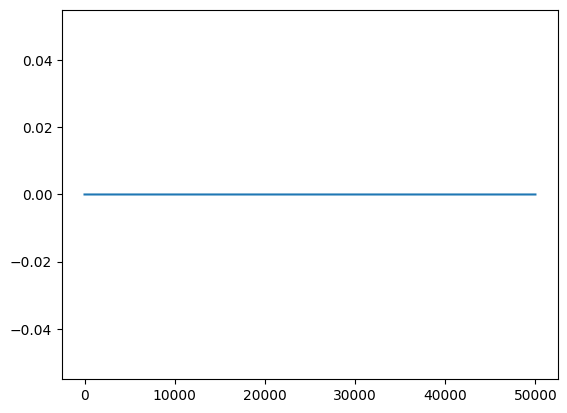

In [30]:
plt.plot(np.cumsum(info['weig_reward']['r_op']))

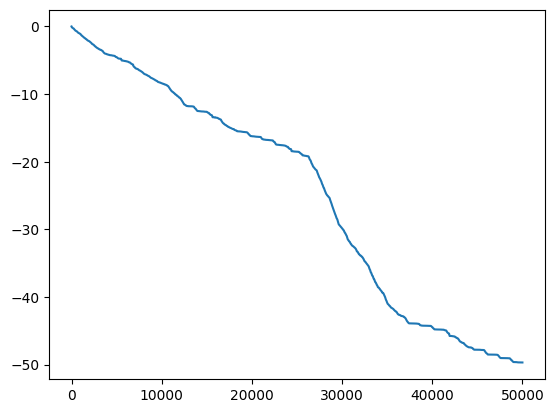

In [31]:
plt.plot(np.cumsum(info['weig_reward']['r_deg']))

In [32]:
print(info['soc'])

[0.50156224 0.5031001  0.5046637  ... 0.8        0.8        0.8       ]


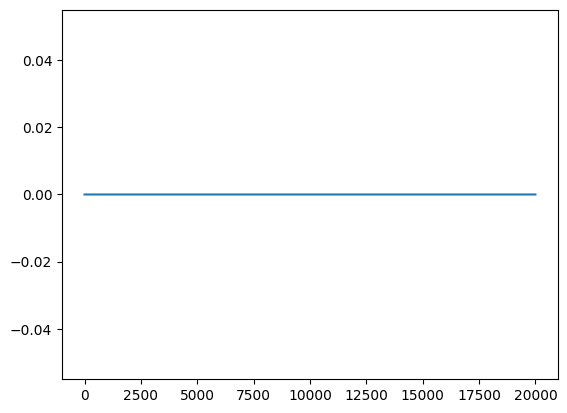

In [50]:
plt.plot(np.cumsum(info['weig_reward']['r_op']))

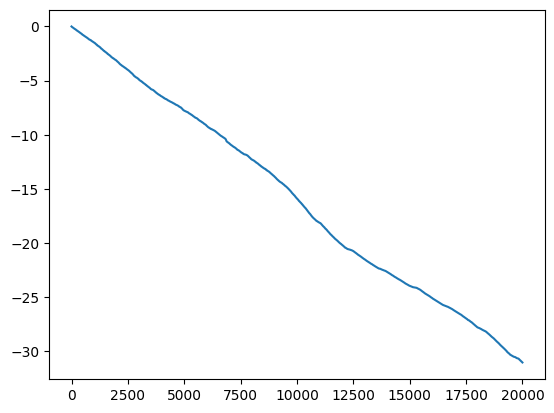

In [51]:
plt.plot(np.cumsum(info['weig_reward']['r_deg']))

In [52]:
print(info['soc'])

[0.49931747 0.4984794  0.4979092  ... 0.7482996  0.74917775 0.7501837 ]
